# Read and Preprocess data

## import and functions

In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from TrackSelectorDNN.data_manager.dataset import TrackDatasetFromFile
from trackkit import preprocessing as pre
from trackkit import plotting as plot
from trackkit import summary as summ

In [35]:
INPUT_PATH  = "/shared/data/100_tracks_skip-connections_GNN.root"
OUTPUT_PATH = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train-val_dataset_skip-connections_GNN.pt"
OUTPUT_PATH_TRAIN = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train_dataset_skip-connections_GNN.pt"
OUTPUT_PATH_VAL  = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_val_dataset_skip-connections_GNN.pt"
MAX_HITS = 16

LOW_PERCENTILE  = 0.001
HIGH_PERCENTILE = 0.999
EPSILON = 1.e-8

# For the preselector

ONE_HOT_CONFIG = {
    "hltPixelTrack_ndof":       [3, 5, 7, 9],
}

# Continuous features used by the preselector (normalized)
PRE_CONTINUOUS_FEATURES = [
    "hltPixelTrack_chi2",
    "hltPixelTrack_eta",
    "hltPixelTrack_vx",
    "hltPixelTrack_vy",
    "hltPixelTrack_dxyBS",
]


#For the full DNN
recHitBranches = [
    "hltPixelTrackRecHits_globalX",
    "hltPixelTrackRecHits_globalY",
    "hltPixelTrackRecHits_globalZ",
    "hltPixelTrackRecHits_globalR",
    "hltPixelTrackRecHits_globalEta",
    "hltPixelTrackRecHits_globalPhi",
    "hltPixelTrackRecHits_globalErrX",
    "hltPixelTrackRecHits_globalErrY",
    "hltPixelTrackRecHits_globalErrZ",
]

recHitExtraBranches = [
    "hltPixelTrackRecHits_side",
    "hltPixelTrackRecHits_subdetId",
    "hltPixelTrackRecHits_layer",
]

ONE_HOT_CONFIG_EXTRA = {
    "hltPixelTrackRecHits_side":     [0,1,2],
    "hltPixelTrackRecHits_subdetId": [1,2,5],
}

CONTINUOUS_EXTRA = [
    "hltPixelTrackRecHits_layer",
]

recoPixelTrackBranches = [
    "hltPixelTrack_matched",
    "hltPixelTrack_isHighPurity",
    "hltPixelTrack_charge",
    "hltPixelTrack_chi2",
    "hltPixelTrack_dXY",
    "hltPixelTrack_dZ",
    "hltPixelTrack_dZError",
    "hltPixelTrack_dsz",
    "hltPixelTrack_dszErr",
    "hltPixelTrack_dxyError",
    "hltPixelTrack_eta",
    "hltPixelTrack_etaErr",
    "hltPixelTrack_lambdaErr",
    "hltPixelTrack_ndof",
    "hltPixelTrack_phi",
    "hltPixelTrack_phiErr",
    "hltPixelTrack_pt",
    "hltPixelTrack_ptErr",
    "hltPixelTrack_qoverp",
    "hltPixelTrack_qoverpErr",
    "hltPixelTrack_vx",
    "hltPixelTrack_vy",
    "hltPixelTrack_vz",
    "hltPixelTrack_dzBS",
    "hltPixelTrack_dxyBS"
]


In [3]:
def one_hot_encode_feature(x, values=None, cap=None):
    """
    x: (N,) array
    values: explicit categorical values
    bins: explicit integer bins
    cap: value above which everything goes to last bin
    """
    if cap is not None:
        x = np.minimum(x, cap)

    if values is not None:
        return np.stack([(x == v).astype(np.float32) for v in values], axis=1)

    raise ValueError("Specify values or bins")

In [4]:
def preprocess_edge_features(
    recHitFeatures,
    isRecHit,
    recHitBranches,
    max_hits=16,
    eps=1e-8,
    fill_value=0.0,
):
    """
    Preprocess recHits per track:
      - sort hits by increasing radius
      - compute finite differences
      - compute angular differences using cartesian dot product

    Parameters
    ----------
    recHitFeatures : np.ndarray
        Shape (n_tracks, max_hits, n_features)
    isRecHit : np.ndarray (bool)
        Shape (n_tracks, max_hits)
    recHitBranches : list[str]
        Feature name ordering
    max_hits : int
    eps : float
        Numerical stability constant
    fill_value : float
        Value used to fill invalid deltas

    Returns
    -------
    dict of np.ndarray
    """

    # ---- feature indices ----
    IDX = {name: recHitBranches.index(name) for name in recHitBranches}

    X = recHitFeatures[:, :, IDX["hltPixelTrackRecHits_globalX"]]
    Y = recHitFeatures[:, :, IDX["hltPixelTrackRecHits_globalY"]]
    Z = recHitFeatures[:, :, IDX["hltPixelTrackRecHits_globalZ"]]
    R = recHitFeatures[:, :, IDX["hltPixelTrackRecHits_globalR"]]
    ETA =  recHitFeatures[:, :, IDX["hltPixelTrackRecHits_globalEta"]]
    
    # ---- sort by radius ----
    r_sort = R.copy()
    r_sort[~isRecHit] = np.inf

    sort_idx = np.argsort(r_sort, axis=1)

    recHitSorted = np.take_along_axis(
        recHitFeatures,
        sort_idx[:, :, None],
        axis=1,
    )

    isRecHitSorted = np.take_along_axis(
        isRecHit,
        sort_idx,
        axis=1,
    )

    # ---- extract sorted coords ----
    Xs = np.take_along_axis(X, sort_idx, axis=1)
    Ys = np.take_along_axis(Y, sort_idx, axis=1)
    Zs = np.take_along_axis(Z, sort_idx, axis=1)
    Rs = np.take_along_axis(R, sort_idx, axis=1)
    ETAs = np.take_along_axis(ETA, sort_idx, axis=1)

    # ---- finite differences ----
    dX = np.diff(Xs, axis=1)
    dY = np.diff(Ys, axis=1)
    dZ = np.diff(Zs, axis=1)
    dR = np.diff(Rs, axis=1)
    dETA = np.diff(ETAs, axis=1)

    # ---- validity mask for deltas ----
    valid_edge = isRecHitSorted[:, :-1] & isRecHitSorted[:, 1:]

    # ---- angular difference via dot product ----
    dot = Xs[:, :-1] * Xs[:, 1:] + Ys[:, :-1] * Ys[:, 1:]
    cross = Xs[:, :-1] * Ys[:, 1:] - Ys[:, :-1] * Xs[:, 1:]
    dphi = np.arctan2(cross, dot)


    # ---- mask invalid transitions ----
    for arr in (dX, dY, dZ, dR, dETA, dphi):
        arr[~valid_edge] = fill_value

    edge_features_name = [
        "delta_r",
        "delta_z",
        "delta_phi",
    ]

    edge_features = np.stack(
        [dR, dZ, dphi],
        axis=2
    )
    
    return recHitSorted, isRecHitSorted, edge_features, edge_features_name, valid_edge
    '''
    {
        "recHitFeatures_sorted": recHitSorted,
        "isRecHit_sorted": isRecHitSorted,
        "sort_idx": sort_idx,
        "delta_x": dX,
        "delta_y": dY,
        "delta_z": dZ,
        "delta_r": dR,
        "delta_eta": dETA,
        "delta_phi": dphi,
        "valid_delta": valid,
    }
    '''

In [5]:
def plot_histogram(data, mask, title, xlabel, bins=100, logy=True):
    values = data[mask].flatten()
    values = values[np.isfinite(values)]

    plt.figure()
    plt.hist(values, bins=bins)
    if logy:
        plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel("Entries")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Preprocess input features for DNN

### Read Data

In [9]:
# ------ Load File ------ 
file = uproot.open(INPUT_PATH)
events = file["Events"]
data = events.arrays(library="ak")

# ------  Extract Track Features ------  
recoPixelTrackList = []
for b in recoPixelTrackBranches:
    arr = ak.to_numpy(ak.flatten(data[b]))  # (n_tracks,)
    recoPixelTrackList.append(arr)

recoPixelTrackFeatures = np.stack(recoPixelTrackList[2:], axis=1)  # (n_tracks, n_features)
recoPixelTrackLabels = np.array(recoPixelTrackList[0])
recoPixelTrackIsHighPurity = np.array(recoPixelTrackList[1])
recoPixelTrackFeatures_names = recoPixelTrackBranches[2:]  # skip 'hltPixelTrack_matched and IsHP' (label)

mask_true = (recoPixelTrackLabels==1)
mask_fake = (recoPixelTrackLabels==0)

# ------ Extract Hit Features ------ 
recHitFeaturesList = []
for b in recHitBranches:
    arr = ak.to_numpy(ak.flatten(data[b])).reshape(-1,MAX_HITS)  # (n_tracks, MAX_HITS)
    recHitFeaturesList.append(arr)

recHitFeatures = np.stack(recHitFeaturesList, axis=2)  # (n_tracks, MAX_HITS, n_features)

# Create mask (1 = real hit, 0 = padded)
mask = np.isnan(recHitFeatures[:,:,-1])  # (n_tracks, MAX_HITS)

# Replace NaNs with 0.0
recHitFeatures[mask] = 0
isRecHit = ~mask

# ------ Extract Hit Extra Features ------ 
recHitExtraFeaturesList = []
for b in recHitExtraBranches:
    arr = ak.to_numpy(ak.flatten(data[b])).reshape(-1,MAX_HITS)  # (n_tracks, MAX_HITS)
    recHitExtraFeaturesList.append(arr)

recHitExtraFeatures = np.stack(recHitExtraFeaturesList, axis=2)  # (n_tracks, MAX_HITS, n_features)

# Create mask (1 = real hit, 0 = padded)
maskExtra = (recHitExtraFeatures[:,:,-1] == 4294967295)  # (n_tracks, MAX_HITS)

# Replace NaNs with 0.0
recHitExtraFeatures[maskExtra] = 0
isRecHitExtra = ~maskExtra

# ------ Process Edge Features ------ 
recHitFeatures, isRecHit, edge_features, edge_features_name,valid_edge = preprocess_edge_features(
    recHitFeatures,
    isRecHit,
    recHitBranches,
    max_hits=MAX_HITS,
)


### Pixel Track Features

In [12]:
summary = summ.summarize_features(recoPixelTrackFeatures, recoPixelTrackFeatures_names)
summary_df = summ.print_summary_table(summary, sort_by="skew", top=15)
issues = summ.flag_outliers(summary)

                feature        min          max        mean          std  zeros(%)  NaNs(%)       skew
    hltPixelTrack_ptErr   0.010045 1.433223e+09 3053.136719 1.783268e+06       0.0      0.0 768.267251
 hltPixelTrack_dxyError   0.000555 8.785193e+02    0.017984 1.154751e+00       0.0      0.0 664.525964
   hltPixelTrack_phiErr   0.000133 2.701934e+02    0.005168 3.621666e-01       0.0      0.0 636.047572
       hltPixelTrack_pt   0.714977 9.394304e+05    7.379144 1.301150e+03       0.0      0.0 603.681349
  hltPixelTrack_dZError   0.001625 1.035379e+00    0.032397 6.961371e-02       0.0      0.0   4.370403
   hltPixelTrack_dszErr   0.000716 6.550348e-02    0.006434 3.765531e-03       0.0      0.0   2.449599
     hltPixelTrack_ndof   3.000000 2.500000e+01    4.965565 3.799633e+00       0.0      0.0   2.029259
     hltPixelTrack_chi2   0.002793 2.032610e+02   13.149116 9.695202e+00       0.0      0.0   1.598407
   hltPixelTrack_etaErr   0.000169 7.769307e-03    0.001549 7.603056e-04 

In [13]:
N = recoPixelTrackLabels.shape[0]
N_true = recoPixelTrackLabels.sum()
N_fake = N - N_true

w_true = N / (2 * N_true)
w_fake = N / (2 * N_fake)

print(w_true, w_fake)
print(recoPixelTrackLabels.sum()/recoPixelTrackLabels.shape[0])

2.1917536655381484 0.6477756514394634
0.2281278265261773


In [14]:
do_log_track = []
# Variables to log-transform and clip
log_vars = ["hltPixelTrack_pt", "hltPixelTrack_ptErr", 
            "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
            "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
            "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr"]

recoPixelTrackFeatures_proc = recoPixelTrackFeatures.copy()
for i, name in enumerate(recoPixelTrackFeatures_names):
    do_log_track.append(name in log_vars)
    if name in log_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x = np.log10(EPSILON+x)
        recoPixelTrackFeatures_proc[:, i] = x
clip_min_track = []
clip_max_track = []
# Variables to just clip
clip_vars = [
    "hltPixelTrack_pt", "hltPixelTrack_ptErr", 
    "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
    "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
    "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr",
    "hltPixelTrack_dXY", "hltPixelTrack_dsz", 
    "hltPixelTrack_vx", "hltPixelTrack_vy"]

for i, name in enumerate(recoPixelTrackFeatures_names):
    if name in clip_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x, lo, hi = pre.clip_outliers(x, low=LOW_PERCENTILE, high=HIGH_PERCENTILE)
        recoPixelTrackFeatures_proc[:, i] = x
        clip_min_track.append(lo)
        clip_max_track.append(hi)
    else:
        clip_min_track.append(np.nan)
        clip_max_track.append(np.nan)

recoPixelTrackFeaturesNorm, recoPixelTrack_mean, recoPixelTrack_std = pre.normalize_2d(recoPixelTrackFeatures_proc)
summary_norm = summ.summarize_features(recoPixelTrackFeaturesNorm, recoPixelTrackFeatures_names)
summary_norm_df = summ.print_summary_table(summary_norm, sort_by="skew", top=15)
issues = summ.flag_outliers(summary_norm)

                feature       min      max          mean      std  zeros(%)  NaNs(%)      skew
    hltPixelTrack_ptErr -1.542430 8.239111  8.361299e-05 1.000144       0.0      0.0  2.558645
       hltPixelTrack_pt -1.036741 7.114894  6.420517e-06 1.000126       0.0      0.0  2.431553
     hltPixelTrack_ndof -0.516518 5.264718  2.803969e-08 0.998481       0.0      0.0  2.029258
 hltPixelTrack_dxyError -2.319978 5.461794 -1.437617e-04 1.000174       0.0      0.0  1.606487
  hltPixelTrack_dZError -1.490228 3.388750 -6.442766e-05 1.000151       0.0      0.0  1.249884
   hltPixelTrack_phiErr -2.807746 5.394756  1.296263e-04 1.000178       0.0      0.0  1.083834
     hltPixelTrack_chi2 -4.640637 2.222801  1.053144e-04 1.000111       0.0      0.0 -0.922484
hltPixelTrack_qoverpErr -3.744416 2.107399 -4.200823e-05 1.000146       0.0      0.0 -0.897938
hltPixelTrack_lambdaErr -3.660941 1.824299 -8.621267e-05 1.000134       0.0      0.0 -0.814926
   hltPixelTrack_etaErr -3.359009 2.379268  8.2349

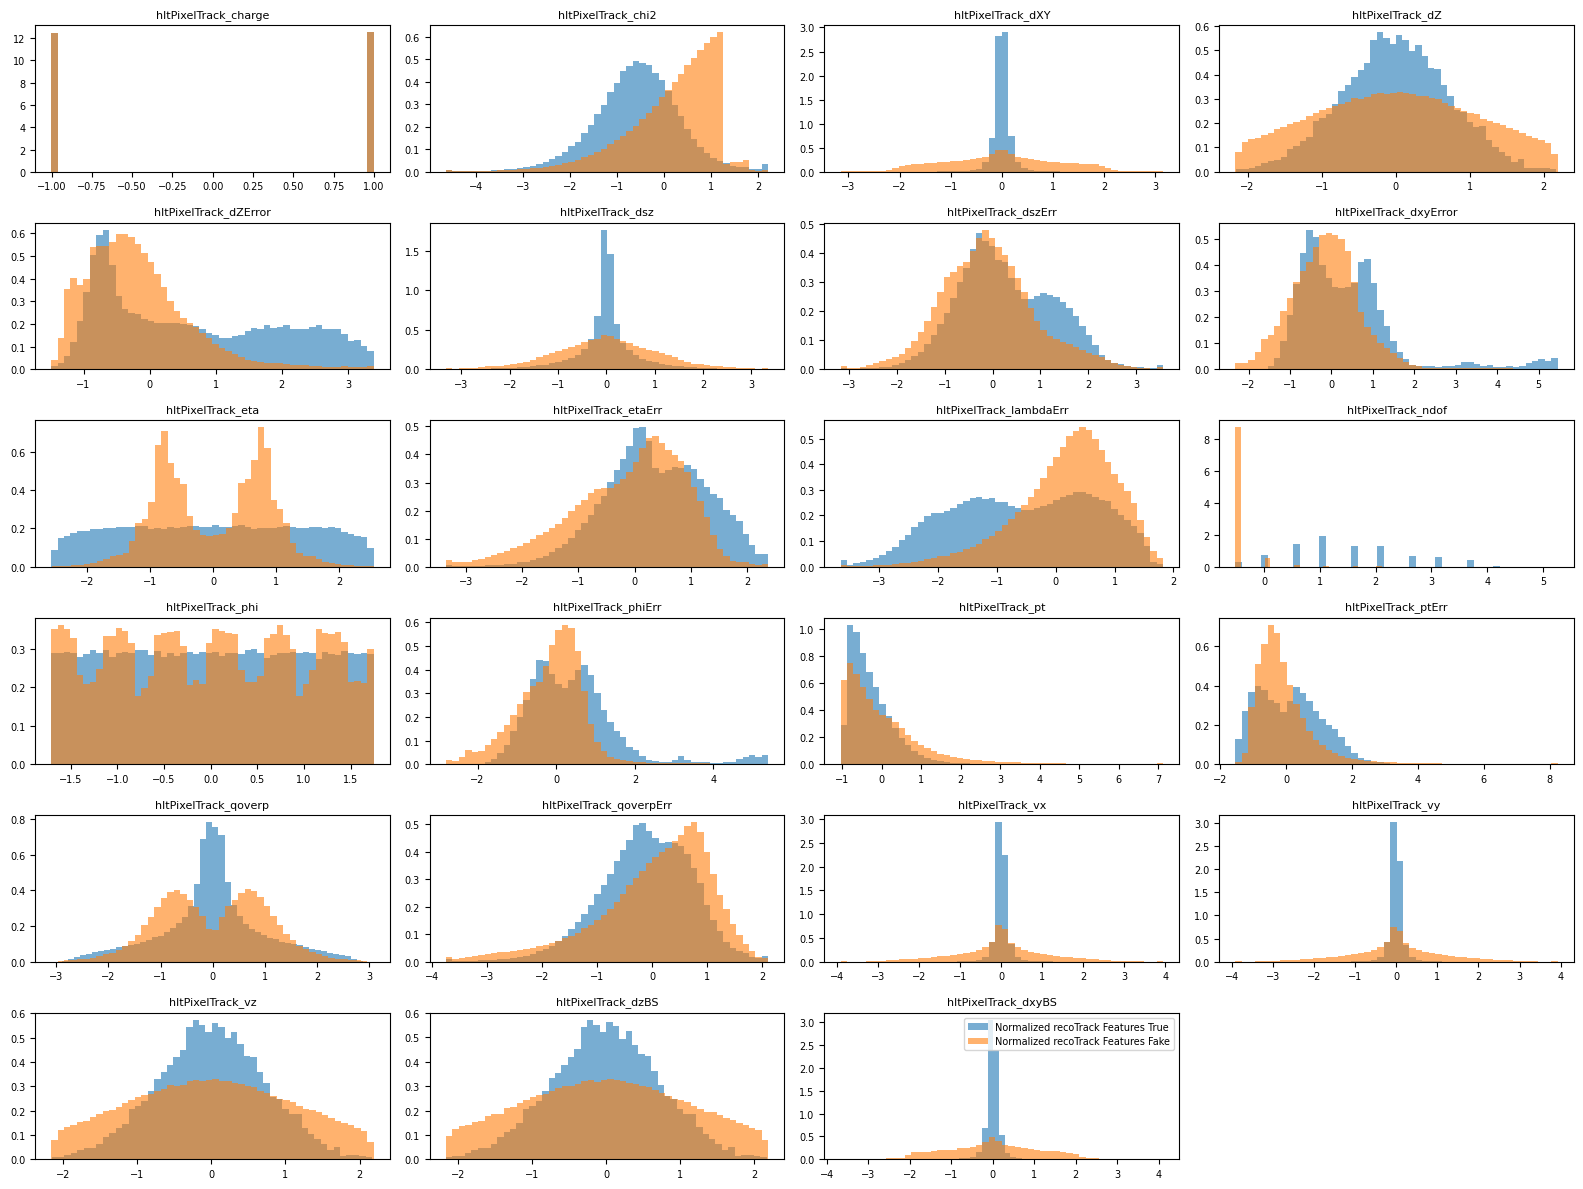

In [15]:
plot.plot_feature_distributions(
    X_ref=recoPixelTrackFeaturesNorm,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Normalized recoTrack Features",)
)

### RecHit Features

In [16]:
summary_recHits = summ.summarize_recHits(recHitFeatures, isRecHit, recHitBranches)
summary_recHits_df = summ.print_summary_table(summary_recHits, sort_by="skew", top=15)
issues_recHits = summ.flag_outliers(summary_recHits)

                        feature       n           min        max      mean       std  zeros(%)      skew
hltPixelTrackRecHits_globalErrY 3393514  8.275480e-36   0.001625  0.000139  0.000343  1.770760  2.609228
hltPixelTrackRecHits_globalErrX 3393514  6.770847e-36   0.001572  0.000139  0.000344  1.290639  2.606428
hltPixelTrackRecHits_globalErrZ 3393514  0.000000e+00   0.001793  0.000218  0.000461 36.507202  2.494461
   hltPixelTrackRecHits_globalR 3393514  2.750000e+00  55.250000 14.244451 11.266941  0.000000  1.121048
 hltPixelTrackRecHits_globalEta 3393514 -4.312500e+00   4.312500  0.013053  1.923961  0.002711 -0.010364
   hltPixelTrackRecHits_globalZ 3393514 -2.660000e+02 266.000000  0.382267 68.035362  0.002711  0.005112
   hltPixelTrackRecHits_globalX 3393514 -5.500000e+01  55.000000 -0.022393 12.864547  0.000000 -0.004719
   hltPixelTrackRecHits_globalY 3393514 -5.525000e+01  55.250000  0.007469 12.819695  0.000000 -0.001788
 hltPixelTrackRecHits_globalPhi 3393514 -3.140625e+00  

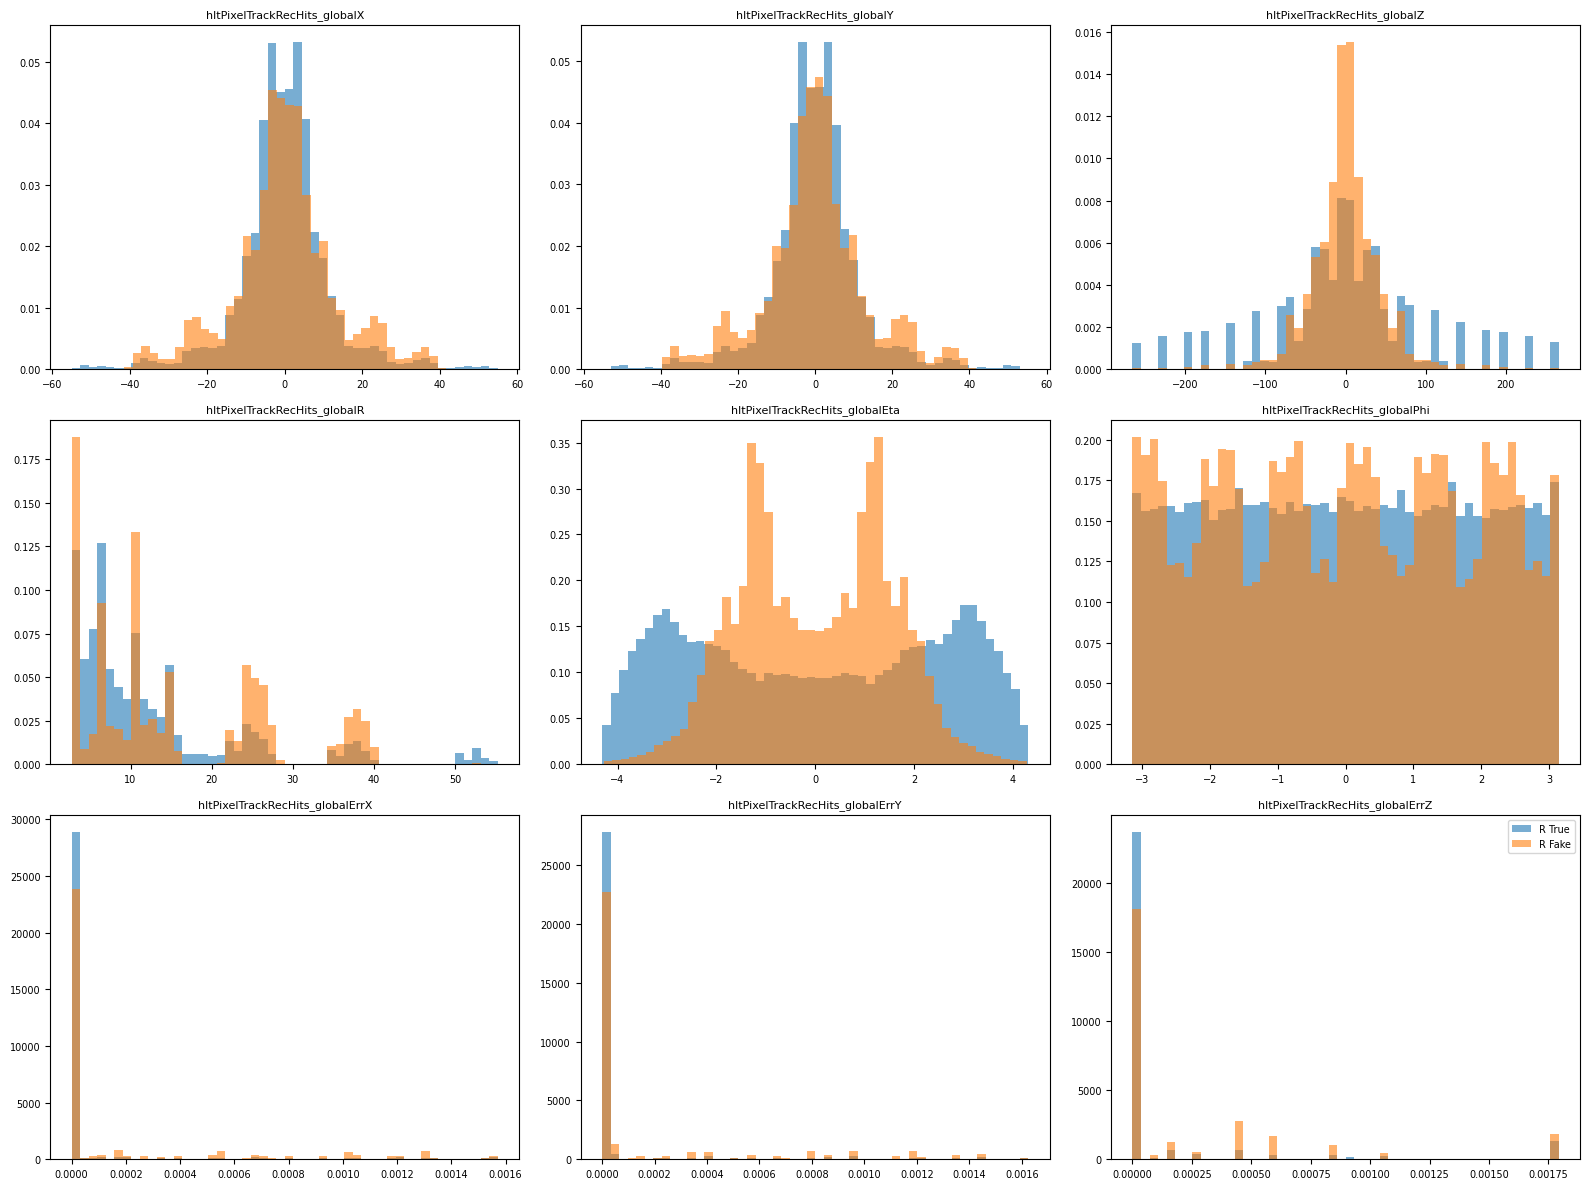

In [17]:
recHitFeatures_plot = np.array(pre.masked_flatten(recHitFeatures, isRecHit)).T
y_hits = np.repeat(recoPixelTrackLabels, isRecHit.sum(axis=1))  # only if you want to compare by label

plot.plot_feature_distributions(
    X_ref=recHitFeatures_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [18]:
do_log_hit = []
log_recHit_vars = ["hltPixelTrackRecHits_globalR", "hltPixelTrackRecHits_globalErrX", "hltPixelTrackRecHits_globalErrY", "hltPixelTrackRecHits_globalErrZ"]
       
recHitFeatures_proc = recHitFeatures.copy()
for f, name in enumerate(recHitBranches):
    do_log_hit.append(name in log_recHit_vars)
    if name in log_recHit_vars:
        print(f, name)
        recHitFeatures_proc = pre.masked_log_transform(recHitFeatures_proc, isRecHit, f, eps=EPSILON, method='log_eps')

recHitFeatures_norm, recHit_mean, recHit_std = pre.normalize_features_masked(recHitFeatures_proc, isRecHit, eps=EPSILON)
clip_min_hit = [np.nan for i in enumerate(recHitBranches)]
clip_max_hit = [np.nan for i in enumerate(recHitBranches)]

3 hltPixelTrackRecHits_globalR
6 hltPixelTrackRecHits_globalErrX
7 hltPixelTrackRecHits_globalErrY
8 hltPixelTrackRecHits_globalErrZ


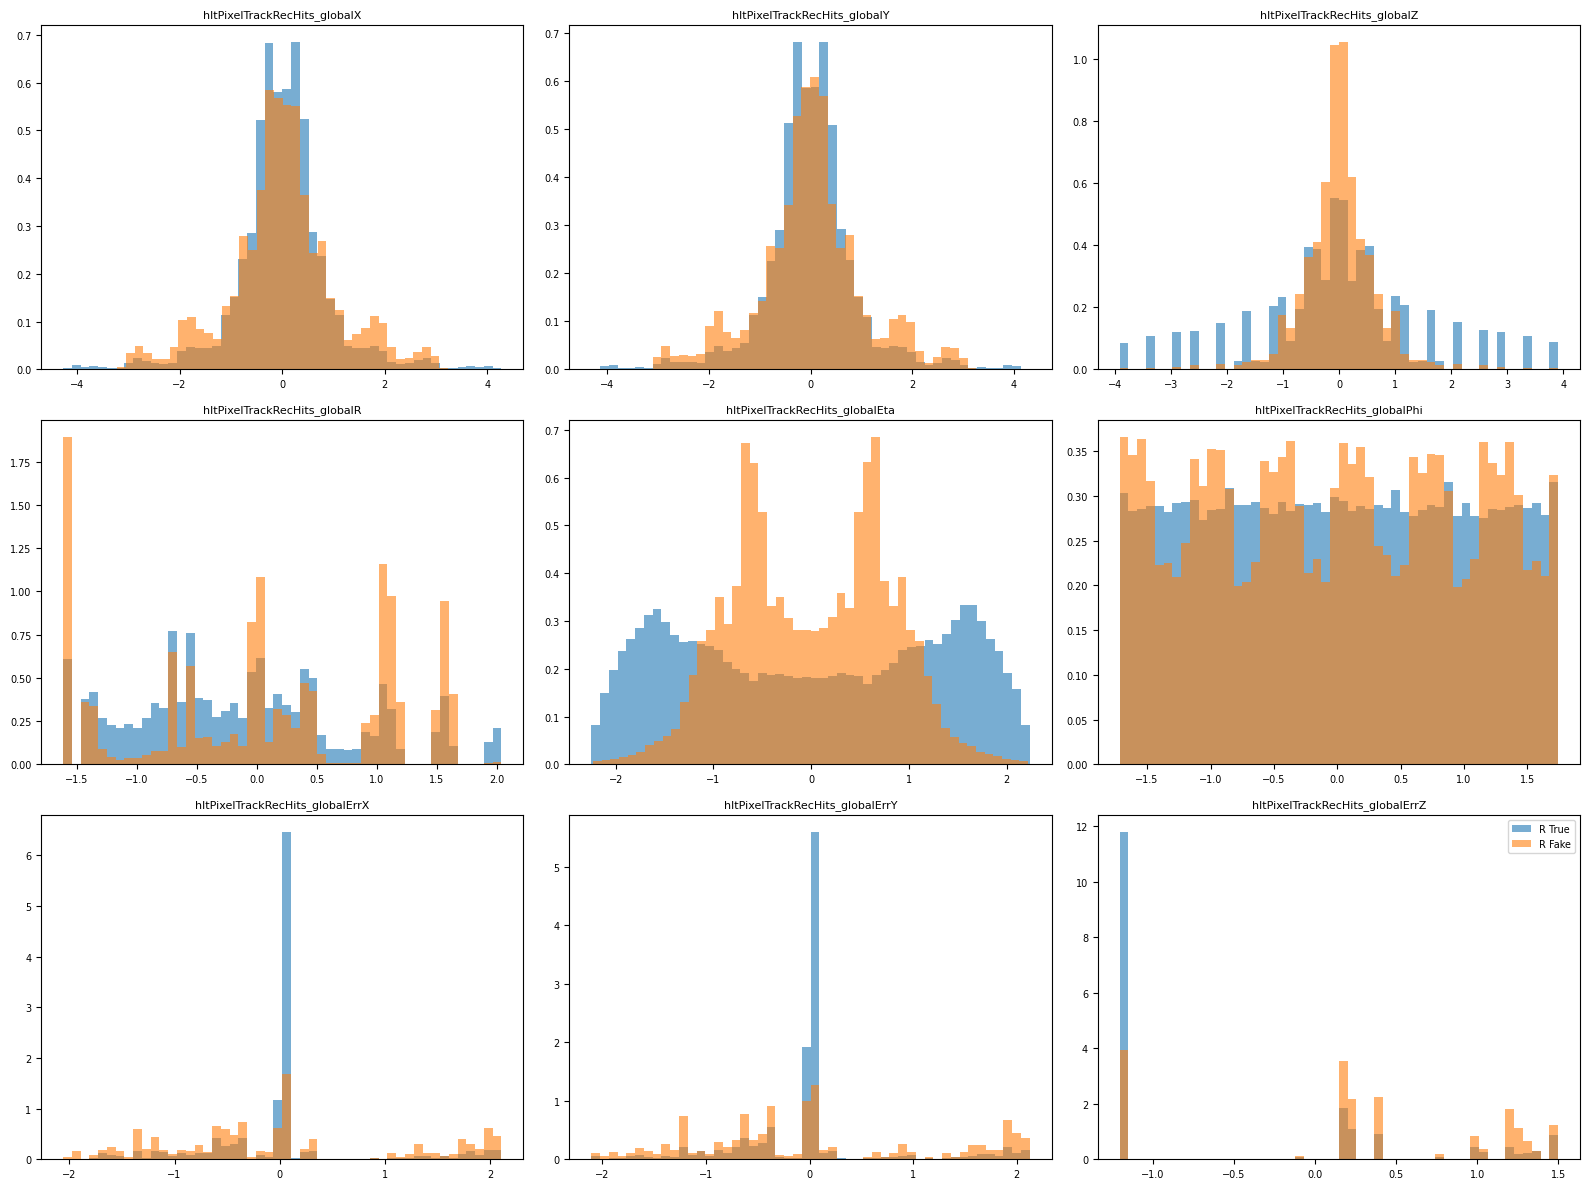

In [19]:
recHitFeatures_norm_plot = np.array(pre.masked_flatten(recHitFeatures_norm, isRecHit)).T
y_hits = np.repeat(recoPixelTrackLabels, isRecHit.sum(axis=1))  # only if you want to compare by label

plot.plot_feature_distributions(
    X_ref=recHitFeatures_norm_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

### RecHit Extra Features

In [31]:
recHitFeaturesExtra_norm, recHitExtra_mean, recHitExtra_std = pre.normalize_features_masked(recHitExtraFeatures, isRecHitExtra, eps=EPSILON)

cont_indices = [recHitExtraBranches.index(n) for n in CONTINUOUS_EXTRA]
extra_cont = recHitFeaturesExtra_norm[...,cont_indices]
recHitExtra_mean = recHitExtra_mean[...,cont_indices]
recHitExtra_std = recHitExtra_std[...,cont_indices]

onehot_extra_blocks = []
onehot_extra_names  = []

for name, values in ONE_HOT_CONFIG_EXTRA.items():
    idx = recHitExtraBranches.index(name)
    oh = one_hot_encode_feature(recHitExtraFeatures[...,idx], values, cap=max(values))
    oh = oh.transpose(0, 2, 1)
    onehot_extra_blocks.append(oh)
    onehot_extra_names.extend([f"{name}=={v}" for v in values])

extra_onehot = np.array(np.concatenate(onehot_extra_blocks, axis=2))

# Final preselector input
extra_features = np.array(np.concatenate([extra_cont, extra_onehot], axis=2))
extra_names = CONTINUOUS_EXTRA + onehot_extra_names

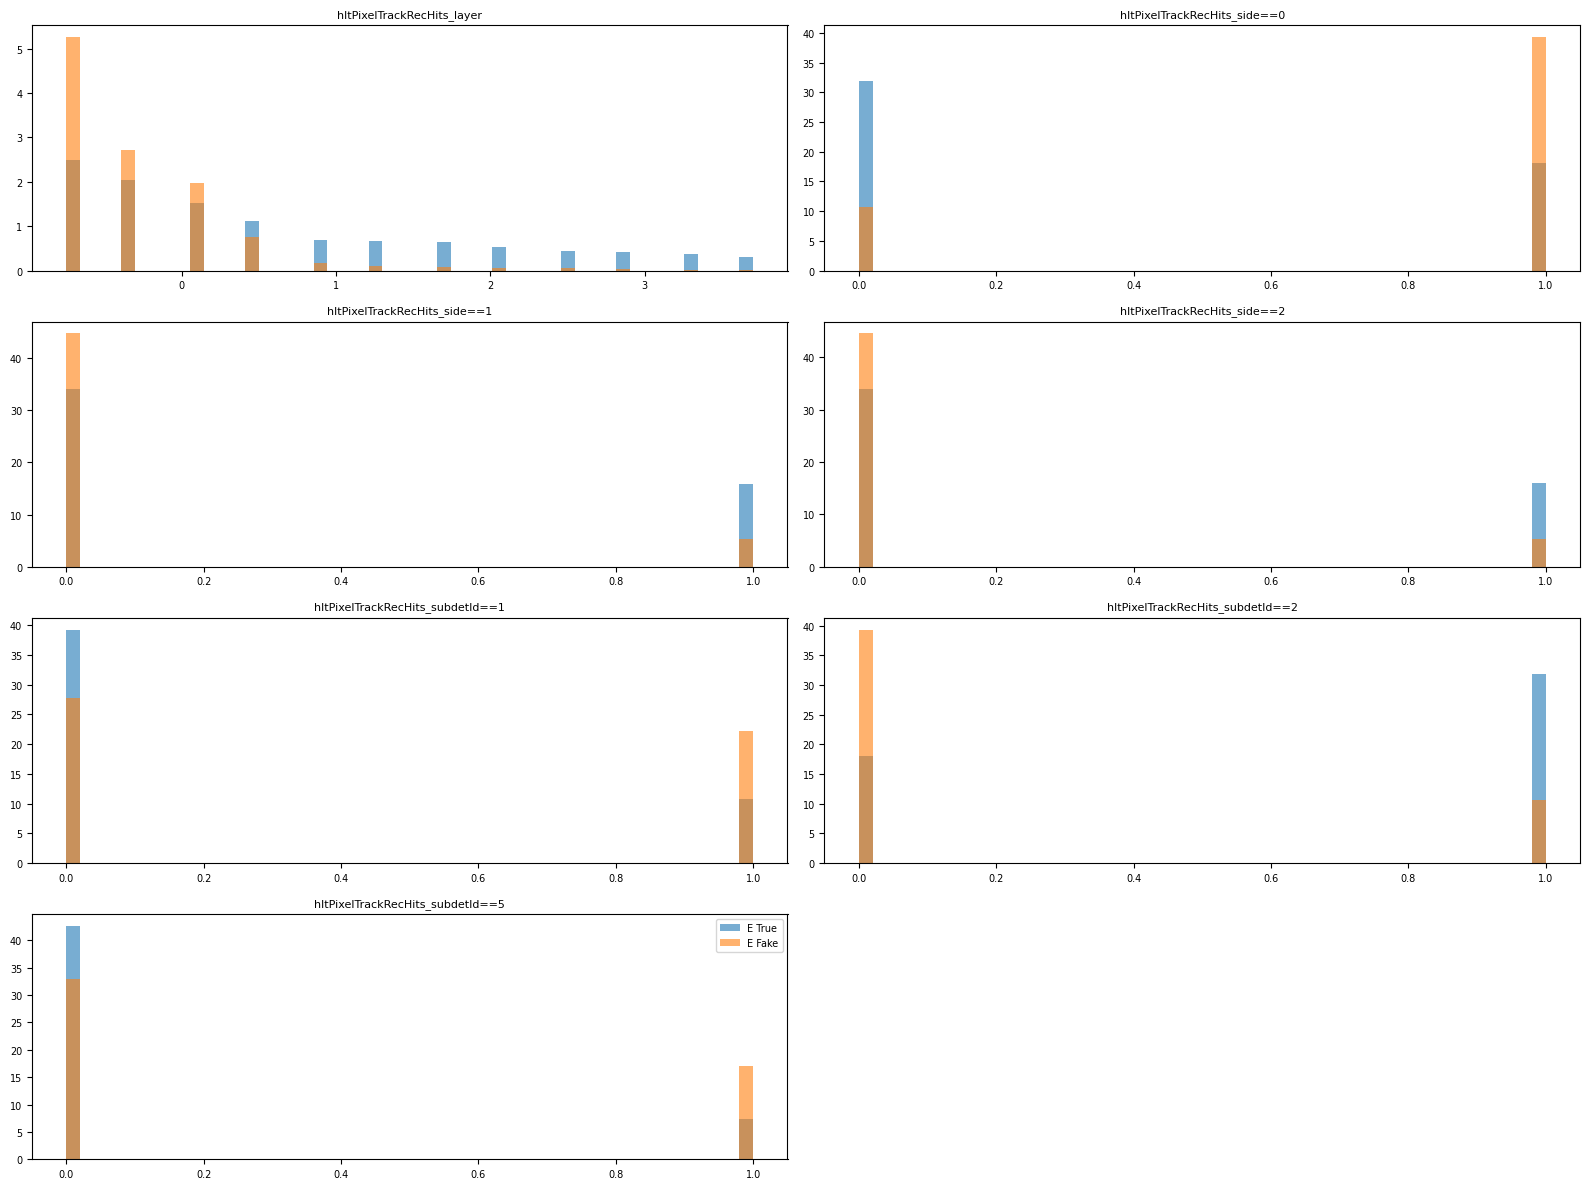

In [32]:
extra_features_plot = np.array(pre.masked_flatten(extra_features, isRecHitExtra)).T
y_hitsExtra = np.repeat(recoPixelTrackLabels, isRecHitExtra.sum(axis=1))  # only if you want to compare by label

plot.plot_feature_distributions(
    X_ref=extra_features_plot,
    feature_names=extra_names,
    y=y_hitsExtra,
    labels=("Extra features recHits"),
    n_cols=2,
    bins=50
)

### Edge Features

In [22]:
summary_edge = summ.summarize_features(edge_features, edge_features_name)
summary_edge_df = summ.print_summary_table(summary_edge, sort_by="skew", top=15)
issues_edge = summ.flag_outliers(summary_edge)

  feature   min  max     mean       std  zeros(%)  NaNs(%)      skew
  delta_r -31.0 31.0 1.548151  6.236082  0.088883      0.0 -0.489742
delta_phi -91.0 90.0 3.173289 13.136486  0.119228      0.0 -0.479325
  delta_z -91.0 91.0 2.661318 10.844836  0.040966      0.0 -0.421508

 Potentially problematic features:


In [23]:
edge_features_norm, edge_mean, edge_std = pre.normalize_features_masked(edge_features, valid_edge, eps=EPSILON)

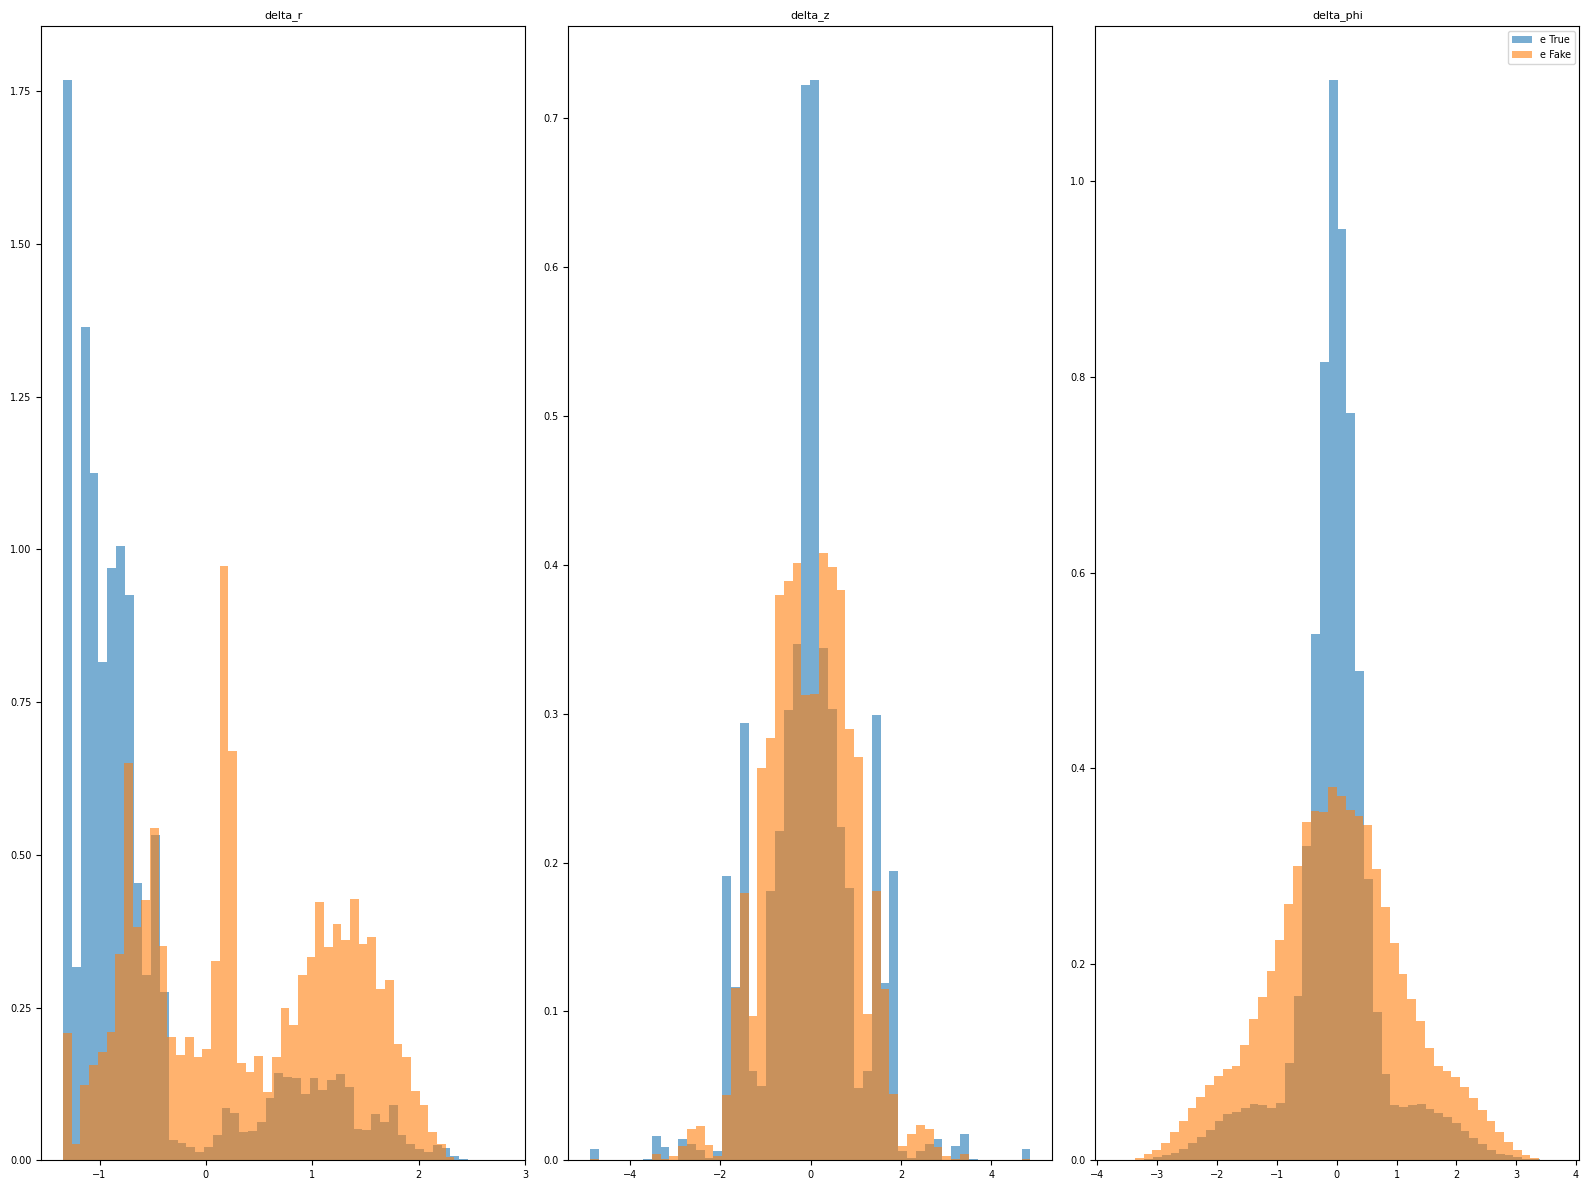

In [24]:
edge_features_plot = np.array(pre.masked_flatten(edge_features_norm, valid_edge)).T
y_edge = np.repeat(recoPixelTrackLabels, valid_edge.sum(axis=1))  # only if you want to compare by label

plot.plot_feature_distributions(
    X_ref=edge_features_plot,
    feature_names=edge_features_name,
    y=y_edge,
    labels=("edge features"),
    n_cols=3,
    bins=50
)

## Preprocess input features for Preselector

In [25]:
cont_indices = [recoPixelTrackFeatures_names.index(n) for n in PRE_CONTINUOUS_FEATURES]
X_cont = recoPixelTrackFeaturesNorm[:, cont_indices]
onehot_blocks = []
onehot_names  = []

for name, values in ONE_HOT_CONFIG.items():
    idx = recoPixelTrackFeatures_names.index(name)
    oh = one_hot_encode_feature(recoPixelTrackFeatures[:, idx], values, cap=max(values))
    onehot_blocks.append(oh)
    onehot_names.extend([f"{name}=={v}" for v in values])

X_onehot = np.concatenate(onehot_blocks, axis=1)

# Final preselector input
X_pre = np.concatenate([X_cont, X_onehot], axis=1)
pre_names = PRE_CONTINUOUS_FEATURES + onehot_names

In [26]:
pre_names

['hltPixelTrack_chi2',
 'hltPixelTrack_eta',
 'hltPixelTrack_vx',
 'hltPixelTrack_vy',
 'hltPixelTrack_dxyBS',
 'hltPixelTrack_ndof==3',
 'hltPixelTrack_ndof==5',
 'hltPixelTrack_ndof==7',
 'hltPixelTrack_ndof==9']

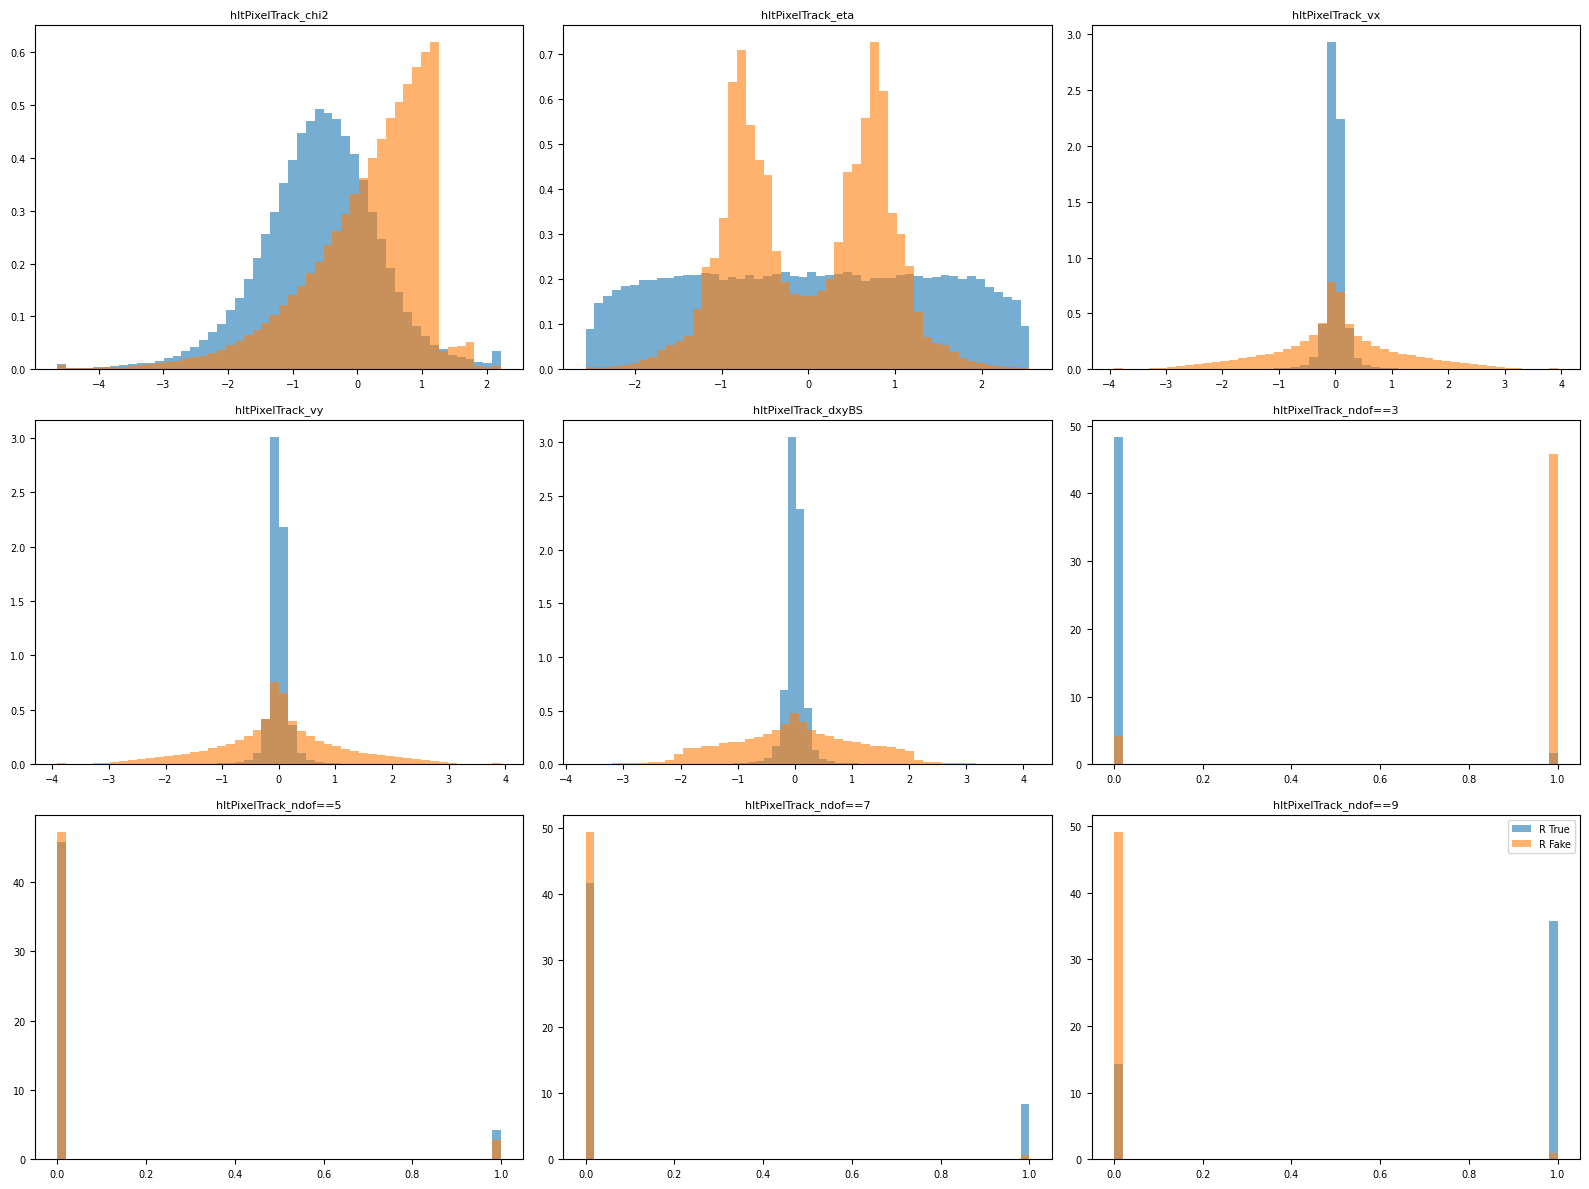

In [27]:
plot.plot_feature_distributions(
    X_ref=X_pre,
    feature_names=pre_names,
    y=recoPixelTrackLabels,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [28]:
def plot_feature_2d(
    X,
    feature_names,
    i,
    j,
    y=None,
    max_points=100_000,
    bins=100,
    figsize=(5, 5),
    density=True,
    cmap_true="Blues",
    cmap_fake="Reds",
):
    assert i < X.shape[1] and j < X.shape[1]

    # Subsample for speed
    N = X.shape[0]
    if N > max_points:
        idx = np.random.choice(N, max_points, replace=False)
        X = X[idx]
        if y is not None:
            y = y[idx]

    plt.figure(figsize=figsize)

    if y is None:
        plt.hist2d(
            X[:, i],
            X[:, j],
            bins=bins,
            density=density,
            cmap="viridis",
        )
        plt.colorbar(label="Density")
    else:
        mask_true = (y == 1)
        mask_fake = (y == 0)

        plt.hist2d(
            X[mask_fake, i],
            X[mask_fake, j],
            bins=bins,
            density=density,
            cmap=cmap_fake,
            alpha=0.6,
        )
        plt.hist2d(
            X[mask_true, i],
            X[mask_true, j],
            bins=bins,
            density=density,
            cmap=cmap_true,
            alpha=0.6,
        )

        plt.colorbar(label="Density")

    plt.xlabel(feature_names[i])
    plt.ylabel(feature_names[j])
    plt.title(f"{feature_names[i]} vs {feature_names[j]}")
    plt.tight_layout()
    plt.show()

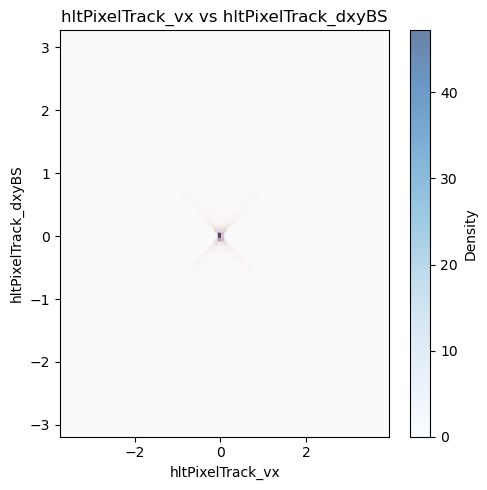

In [29]:
plot_feature_2d(
    X_pre,
    pre_names,
    2, 4,
    y=recoPixelTrackLabels
)

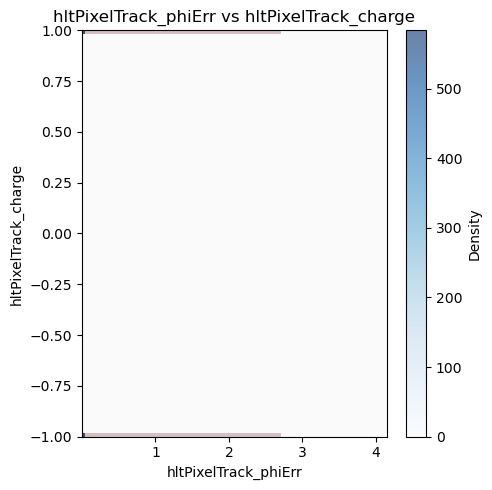

In [30]:
plot_feature_2d(
    recoPixelTrackFeatures,
    recoPixelTrackBranches[2:],
    13, 0,
    y=recoPixelTrackLabels
)

## Save data

In [33]:
save_dict = {
    # --- Core datasets ---
    "recHitFeatures": torch.tensor(recHitFeatures_norm, dtype=torch.float32),
    "isRecHit": torch.tensor(isRecHit, dtype=torch.bool),
    "recoPixelTrackFeatures": torch.tensor(recoPixelTrackFeaturesNorm, dtype=torch.float32),
    "edgeFeatures": torch.tensor(edge_features_norm, dtype=torch.float32),
    "recHitExtraFeatures": torch.tensor(extra_features, dtype=torch.float32), 
    "labels": torch.tensor(recoPixelTrackLabels, dtype=torch.float32),
    "isHighPurity": torch.tensor(recoPixelTrackIsHighPurity, dtype=torch.bool),

    # --- Normalization stats ---
    "recHit_mean": torch.tensor(recHit_mean, dtype=torch.float32),
    "recHit_std": torch.tensor(recHit_std, dtype=torch.float32),
    "recoPixelTrack_mean": torch.tensor(recoPixelTrack_mean, dtype=torch.float32),
    "recoPixelTrack_std": torch.tensor(recoPixelTrack_std, dtype=torch.float32),
    "edge_mean": torch.tensor(edge_mean, dtype=torch.float32),
    "edge_std": torch.tensor(edge_std, dtype=torch.float32),
    "recHitExtra_mean": torch.tensor(recHitExtra_mean, dtype=torch.float32),
    "recHitExtra_std": torch.tensor(recHitExtra_std, dtype=torch.float32),
    
    # --- Metadata ---
    "recHitBranches": recHitBranches,
    "recoPixelTrackBranches": recoPixelTrackBranches[2:],  # exclude label and isHP
    "MAX_HITS": MAX_HITS,
    "EPSILON": EPSILON,
    "LOW_PERCENTILE": LOW_PERCENTILE,
    "HIGH_PERCENTILE": HIGH_PERCENTILE,
    "log_vars": log_vars,
    "clip_vars": clip_vars,
    "log_recHit_vars": log_recHit_vars,
    "do_log_hit": torch.tensor(do_log_hit, dtype=torch.bool),
    "clip_min_hit": torch.tensor(clip_min_hit, dtype=torch.float32),
    "clip_max_hit": torch.tensor(clip_max_hit, dtype=torch.float32),
    "do_log_track": torch.tensor(do_log_track, dtype=torch.bool),
    "clip_min_track": torch.tensor(clip_min_track, dtype=torch.float32),
    "clip_max_track": torch.tensor(clip_max_track, dtype=torch.float32),
   

    # New preselector view
    "recoPixelTrackFeatures_pre": torch.tensor(X_pre, dtype=torch.float32),
    "recoPixelTrackFeatures_pre_names": pre_names,
    "recoPixelTrackFeatures_pre_is_onehot": (
        [False] * len(PRE_CONTINUOUS_FEATURES)
        + [True] * X_onehot.shape[1]
    ),

    # Normalization stats (only for continuous features)
    "recoPixelTrack_pre_mean": torch.tensor(recoPixelTrack_mean[..., cont_indices], dtype=torch.float32),
    "recoPixelTrack_pre_std": torch.tensor(recoPixelTrack_std[..., cont_indices], dtype=torch.float32),
}

torch.save(save_dict, OUTPUT_PATH)
print(f"Saved preselector dataset to {OUTPUT_PATH}")

Saved preselector dataset to /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train-val_dataset_skip-connections_GNN.pt


In [36]:
val_fraction = 0.2
dataset_len = len(save_dict["labels"])
val_len = int(dataset_len * val_fraction)
train_len = dataset_len - val_len

indices = torch.randperm(dataset_len, generator=torch.Generator().manual_seed(42))
train_idx, val_idx = indices[:train_len], indices[train_len:]

def subset_dict(save_dict, indices):
    subset = {}
    ref_len = save_dict["labels"].shape[0]

    for key, value in save_dict.items():
        if torch.is_tensor(value) and value.shape[0] == ref_len:
            subset[key] = value[indices]
        else:
            subset[key] = value

    return subset

train_dict = subset_dict(save_dict, train_idx)
val_dict = subset_dict(save_dict, val_idx)

torch.save(train_dict, OUTPUT_PATH_TRAIN)
torch.save(val_dict, OUTPUT_PATH_VAL)
print(f"✅ Saved train and validation datasets with metadata")


✅ Saved train and validation datasets with metadata
